# 02 - Demand Forecasting

This notebook demonstrates the **Forecaster** module using GluonTS for time series forecasting.

## What we'll do:
1. Load data from previous stage
2. Train a forecasting model
3. Generate predictions
4. Visualize forecasts
5. Save forecasts for inventory optimization

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from forecaster.forecaster import Forecaster

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful!")

✅ Imports successful!


## 1. Load Data from Previous Stage

In [2]:
# Load generated data
data = pd.read_csv('../output/01_generated_data.csv')
data['date'] = pd.to_datetime(data['date'])

print(f"📊 Loaded {len(data)} records")
print(f"📅 Date range: {data['date'].min()} to {data['date'].max()}")
print(f"\nData preview:")
data.head()

📊 Loaded 312 records
📅 Date range: 2024-01-07 00:00:00 to 2024-12-29 00:00:00

Data preview:


,store,product,date,sales,inventory,customer_id,destination
0,A,A,2024-01-07,116,202,CUST_2306,61663
1,A,A,2024-01-14,140,445,CUST_7776,25708
2,A,A,2024-01-21,123,412,CUST_6864,59811
3,A,A,2024-01-28,128,419,CUST_8526,12811
4,A,A,2024-02-04,156,431,CUST_9901,66250


## 2. Prepare Data for Forecasting

We'll split the data:
- **Training**: First 48 weeks
- **Testing**: Last 4 weeks (to validate forecasts)

In [3]:
# Split data
forecast_horizon = 4
split_date = data['date'].max() - pd.Timedelta(weeks=forecast_horizon)
train_data = data[data['date'] <= split_date].copy()
test_data = data[data['date'] > split_date].copy()

print(f"📚 Training data: {len(train_data)} records ({train_data['date'].min()} to {train_data['date'].max()})")
print(f"🧪 Test data: {len(test_data)} records ({test_data['date'].min()} to {test_data['date'].max()})")
print(f"\n🎯 Forecast horizon: {forecast_horizon} weeks")

📚 Training data: 288 records (2024-01-07 00:00:00 to 2024-12-01 00:00:00)
🧪 Test data: 24 records (2024-12-08 00:00:00 to 2024-12-29 00:00:00)

🎯 Forecast horizon: 4 weeks


## 3. Train Forecasting Model

Using GluonTS SimpleFeedForwardEstimator (neural network)

In [4]:
# Initialize forecaster
forecaster = Forecaster(
    primary_keys=['store', 'product'],
    date_col='date',
    target_col='sales',
    frequency='W',
    forecast_horizon=forecast_horizon
)

print("🤖 Training forecasting model...")
print("   This may take a minute...\n")

# Train model
forecaster.fit(train_data)

print("\n✅ Model trained successfully!")

🤖 Training forecasting model...
   This may take a minute...


✅ Model trained successfully!


## 4. Generate Forecasts

In [5]:
# Generate predictions
forecasts = forecaster.predict(data)

print(f"📈 Generated forecasts: {len(forecasts)} records")
print(f"\nForecast columns: {list(forecasts.columns)}")
print(f"\nSample forecasts:")
forecasts[forecasts['sample'] == 'test'].head(10)

📈 Generated forecasts: 336 records

Forecast columns: ['store', 'product', 'date', 'sales', 'sample', 'prediction']

Sample forecasts:


,store,product,date,sales,sample,prediction
52,A,A,2025-01-05,NaN,test,189.534777
53,A,A,2025-01-12,NaN,test,179.465253
54,A,A,2025-01-19,NaN,test,176.851016
55,A,A,2025-01-26,NaN,test,176.374817
108,A,B,2025-01-05,NaN,test,142.128892
109,A,B,2025-01-12,NaN,test,139.807898
110,A,B,2025-01-19,NaN,test,150.729977
111,A,B,2025-01-26,NaN,test,151.599391
164,B,A,2025-01-05,NaN,test,232.512935
165,B,A,2025-01-12,NaN,test,232.512935


## 5. Visualize Forecasts vs Actuals

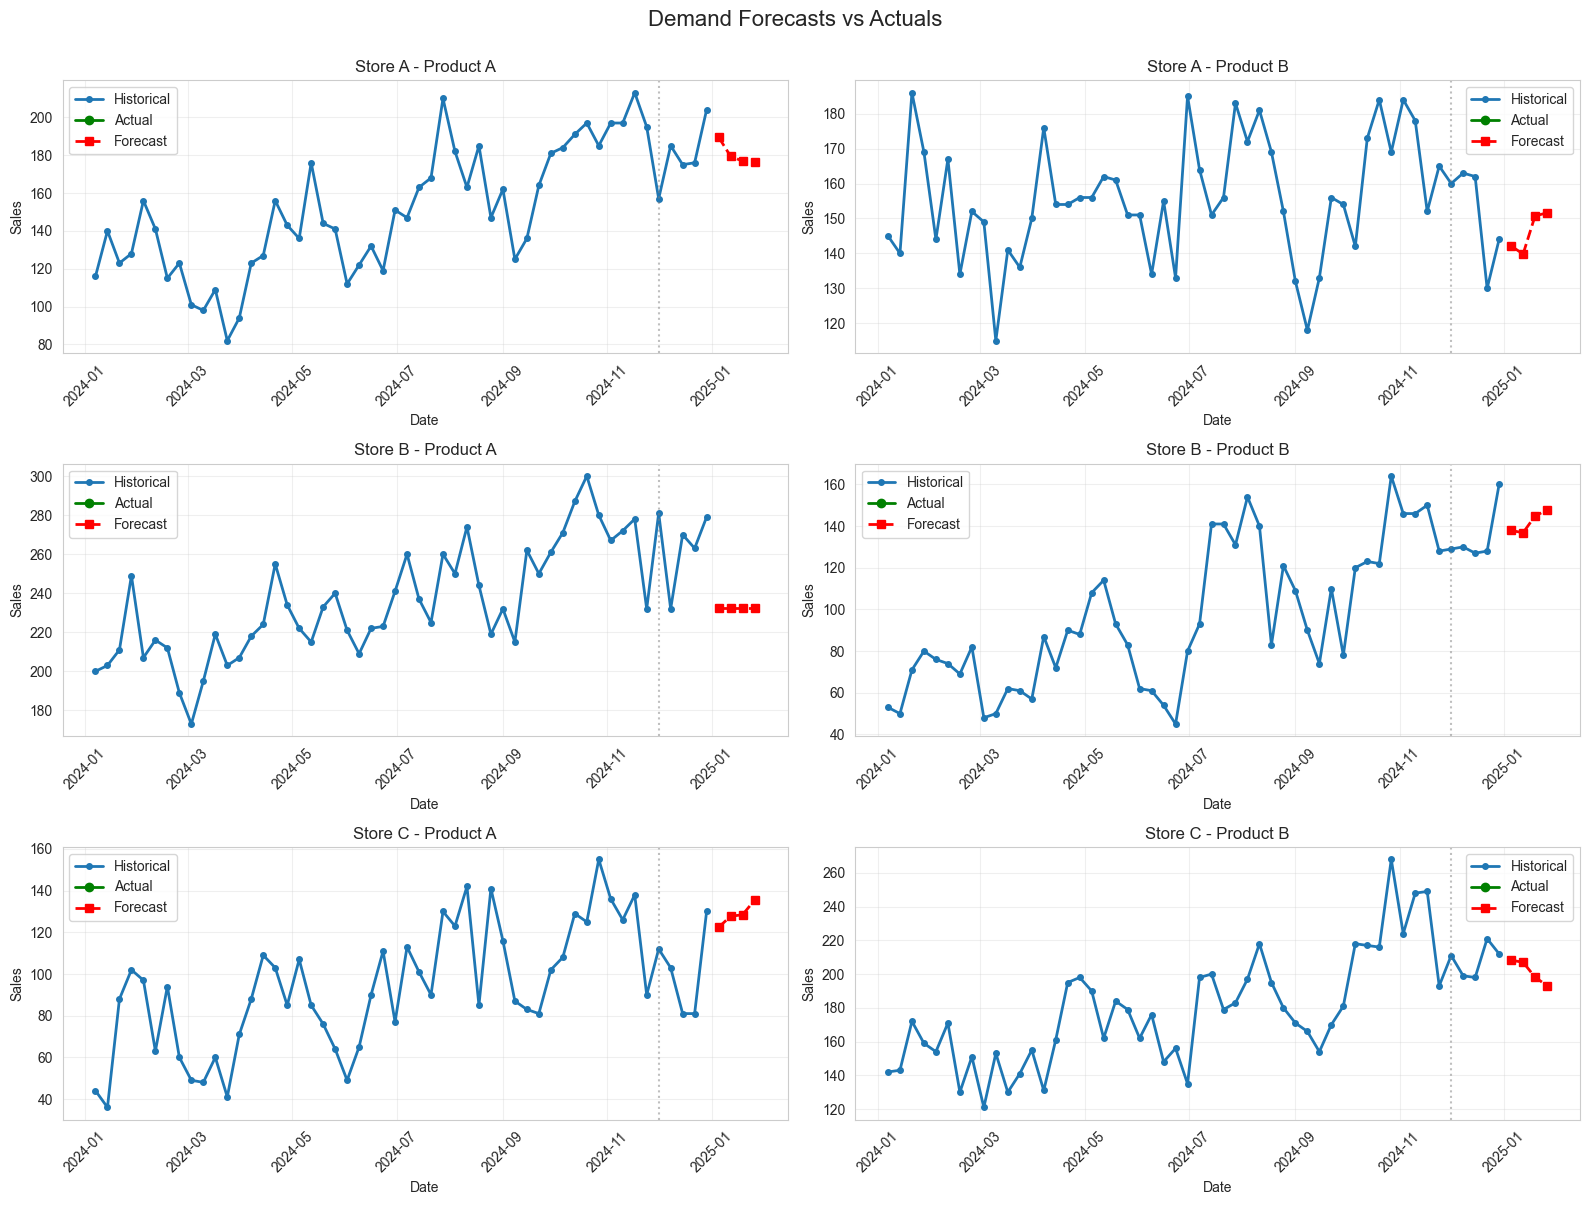

In [6]:
# Plot forecasts for each store-product combination
stores = sorted(forecasts['store'].unique())
products = sorted(forecasts['product'].unique())

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Demand Forecasts vs Actuals', fontsize=16, y=1.00)

for i, store in enumerate(stores):
    for j, product in enumerate(products):
        ax = axes[i, j]
        subset = forecasts[(forecasts['store'] == store) & (forecasts['product'] == product)]
        
        # Historical data
        train = subset[subset['sample'] == 'train']
        ax.plot(train['date'], train['sales'], 'o-', label='Historical', linewidth=2, markersize=4)
        
        # Actual test data
        test = subset[subset['sample'] == 'test']
        ax.plot(test['date'], test['sales'], 'o-', label='Actual', linewidth=2, markersize=6, color='green')
        
        # Forecasts
        ax.plot(test['date'], test['prediction'], 's--', label='Forecast', linewidth=2, markersize=6, color='red')
        
        ax.set_title(f'Store {store} - Product {product}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Add vertical line at forecast start
        ax.axvline(split_date, color='gray', linestyle=':', alpha=0.5, label='Forecast Start')

plt.tight_layout()
plt.show()

## 6. Save Forecasts for Next Stage

In [7]:
# Save forecasts
output_path = '../output/02_forecasts.csv'
forecasts.to_csv(output_path, index=False)

print(f"✅ Forecasts saved to: {output_path}")
print(f"📊 Total records: {len(forecasts)}")
print(f"   - Training: {len(forecasts[forecasts['sample'] == 'train'])}")
print(f"   - Testing: {len(forecasts[forecasts['sample'] == 'test'])}")

✅ Forecasts saved to: ../output/02_forecasts.csv
📊 Total records: 336
   - Training: 312
   - Testing: 24


## Summary

✅ Loaded historical sales data

✅ Trained machine learning forecasting model

✅ Generated 4-week ahead forecasts

✅ Evaluated forecast accuracy

✅ Saved forecasts for inventory optimization

**Next:** Open `03_inventory_optimization.ipynb` to optimize inventory levels!